In [1]:
import numpy as np
from matplotlib import pyplot as plt
import io

In [2]:
def square(patterns):
    x = np.sin(patterns)
    return np.where(x>=0,1,-1)

def generate_data(is_sin):
    training_patterns = np.arange(0,2*np.pi,0.1)
    test_patterns = np.arange(0.05,2*np.pi,0.1)
    

    if is_sin:
        training_targets = np.sin(2*training_patterns)
        test_targets = np.sin(2*test_patterns)
        i = np.arange(training_patterns.shape[0])
        np.random.shuffle(i)
        training_patterns=training_patterns[i]
        training_targets=training_targets[i]

        i = np.arange(test_patterns.shape[0])
        np.random.shuffle(i)
        test_patterns=test_patterns[i]
        test_targets=test_targets[i]
        return training_patterns, training_targets , test_patterns, test_targets
    
    else:
        training_targets = square(training_patterns)
        test_targets = square(test_patterns)
        i = np.arange(training_patterns.shape[0])
        np.random.shuffle(i)
        training_patterns=training_patterns[i]
        training_targets=training_targets[i]

        i = np.arange(test_patterns.shape[0])
        np.random.shuffle(i)
        test_patterns=test_patterns[i]
        test_targets=test_targets[i]
        return training_patterns, training_targets, test_patterns, test_targets


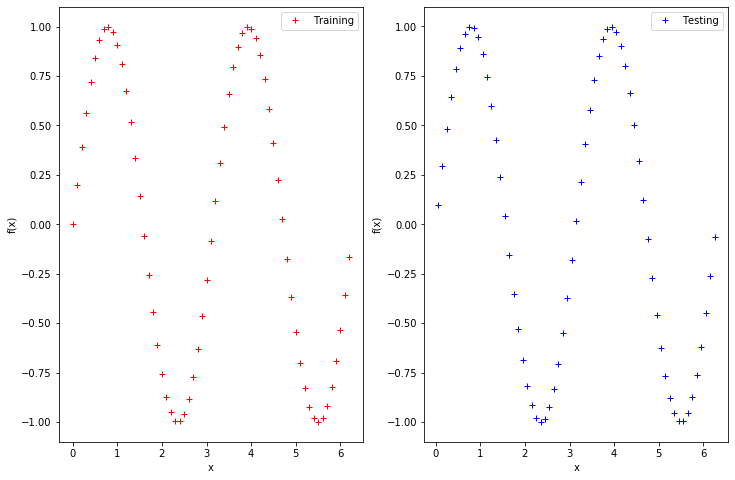

In [3]:
training_patterns, training_targets, test_patterns, test_targets = generate_data(1)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(training_patterns,training_targets, 'r+',label='Training')
ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')
ax1.legend()

ax2.plot(test_patterns,test_targets,'b+',label='Testing')
ax2.set_xlabel('x')
ax2.set_ylabel('f(x)')
ax2.legend()

plt.show()

In [4]:
def evenly_spaced_rbf(n):
    mu_s = np.zeros((n,1))
    for i in range(n):
        mu_s[i] = i*2*np.pi/n
    return mu_s

def random_rbf(n):
    mu_s = np.zeros((n,1))
    for i in range(n):
        mu_s[i] = (2*np.random.random_sample()*np.pi)
    
    return mu_s

def competetive_rbf(n,x_s,iterations,eta,n_winners):
    mu_s = np.zeros((n,1))
    
    for i in range(n):
        mu_s[i] = 2*np.pi*np.random.random_sample()
    random_mu_s = mu_s
      
    mu_before = mu_s
    #plt.scatter(mu_s,np.sin(2*mu_s), c='b', label="Before")

    for i in range(iterations):
        train_vec = x_s[np.random.randint(0,x_s.shape[0])]
        distances = np.empty((0,0))
        for mu in mu_s:
            distances = np.append(distances,(np.linalg.norm(train_vec-mu)))
        
        ind = np.argpartition(distances, -n_winners)[-n_winners:]
        
        for k in ind:
            #mu_s[k] = mu_s[k]+eta*distances[k]
            mu_s[k] = mu_s[k]+eta*(train_vec-mu_s[k])
    
    mu_after = mu_s
    #plt.figure()
    #plt.scatter(mu_s,np.sin(2*mu_s), c='r', label="After")
    return mu_after, mu_before


def competetive_rbf_2D(n,x_s,iterations,eta,n_winners):

    mu_s = np.amax(x_s)*np.random.random_sample((x_s.shape[0],n)) -np.absolute(np.amin(x_s))
    
    random_mu_s = mu_s
    mu_before = mu_s
    #plt.scatter(mu_s[0,:],mu_s[1,:], c='b', label="Before")

    for i in range(iterations):
        train_vec = x_s[:,np.random.randint(0,x_s.shape[1])]
        train_vectors = np.empty((2,0))
        distances = np.empty((0,0))
        for j in range(mu_s.shape[1]):
            train_vec = train_vec.reshape((-1,1))
            distances = np.append(distances,(np.linalg.norm(train_vec-mu_s[:,j])))
            train_vectors = np.append(train_vectors,train_vec,axis=1)
        ind = np.argpartition(distances, -n_winners)[-n_winners:]

        for k in ind:
            mu_s[:,k] = mu_s[:,k]+eta*(train_vectors[:,k]-mu_s[:,k])
    
    mu_after = mu_s
    #plt.scatter(mu_s[0,:],mu_s[1,:], marker='+', c='r', label="After")
    #plt.legend(['Before CL', 'After CL'])
    return mu_after, mu_before


In [5]:
def calculate_mse(f_hat,f):
    return np.mean((f_hat-f)**2)

def calculate_NMAE(f_hat,f):
    return np.mean(np.abs(f_hat-f))

def gaussian(x, mu, sigma):
    return np.exp(-(np.linalg.norm(x-mu))**2/(2*sigma**2))

    
def get_phi(x_s, mu_s,sigma):
    phi_s = np.zeros((x_s.shape[0],mu_s.shape[0]))
    for i, mu in enumerate( mu_s):
        for j,  x in enumerate( x_s):
            phi_s[j,i]=gaussian(mu,x,sigma)
    return phi_s

def get_phi_seq(x_s, mu_s,sigma):
    phi_s = np.zeros(mu_s.shape[1])
    for i, mu in enumerate( mu_s.T):
        phi_s[i]=gaussian(mu,x_s,sigma)
    return phi_s

def train_network_batch(x_s,f,mu_s,sigma):
    phi_s = get_phi(x_s,mu_s,sigma)
    w = np.matmul(np.matmul(phi_s.T,f),np.linalg.inv(np.matmul(phi_s.T,phi_s)))
    f_hat = np.sum(np.multiply(phi_s,w),axis=1)
    nmae = calculate_NMAE(f_hat,f)
    return w, nmae

def train_network_delta_rule(x_s,f,mu_s,sigma,eta, epochs):
    learning_error_list= np.zeros(epochs)
    W=np.random.randn(mu_s.shape[1],2)
    
    for i in range(epochs):
        e_list=[]
        x = np.zeros((2,1))
        for k in range(np.shape(x_s)[1]):
            x[:,0] = x_s[:,k]
            phi = get_phi_seq(x,mu_s,sigma)
            phi = phi.reshape(1,-1)
            e=f[:,k].reshape((2,1))-np.matmul(phi,W).T
            error=0.5*(e**2)
            e_list.append(error)
            W=W+eta*(e*phi).T

        learning_error=np.mean(e_list)
        learning_error_list[i] = learning_error
    
    return W, np.mean(learning_error_list)
    
def predict(x_s,mu_s,sigma,w):
    phi_s = get_phi(x_s,mu_s,sigma)
    w = w.reshape((w.shape[0],1))
    f_hat = np.sum(np.dot(phi_s,w),axis=1)
    return f_hat




In [24]:
addNoise = [False,True]

sigma = 1
sigma_cl = 1
num_of_rbf = 10
eta = 1e-3
iterations = 20
nWinners = 1
repeat = 10

data_testing_es= np.zeros((repeat,len(addNoise)))
data_testing_cl = np.zeros((repeat,len(addNoise)))
data_training_es = np.zeros((repeat,len(addNoise)))
data_training_cl = np.zeros((repeat,len(addNoise)))

for i in range(repeat):
    for j,noise_ in enumerate(addNoise):
        training_patterns, training_targets, test_patterns, test_targets = generate_data(1)
    if noise_:
        noise=np.random.randn(training_patterns.shape[0])*0.1
        noise_test=np.random.randn(test_patterns.shape[0])*0.1
        training_patterns = training_patterns+noise
        test_patterns = test_patterns+noise_test
        
    mu_es = evenly_spaced_rbf(num_of_rbf)
    
    mu_after, mu_before = competetive_rbf(num_of_rbf,training_patterns,iterations,eta,nWinners)
    
    w_cl,nmae_cl = train_network_batch(training_patterns, training_targets,mu_after,sigma_cl)
    w_es,nmae_es = train_network_batch(training_patterns, training_targets,mu_es,sigma)
    
    f_hat_cl = predict(test_patterns,mu_before,sigma,w_cl)
    f_hat_es = predict(test_patterns,mu_es,sigma,w_es)
    
    data_testing_es[i,j] = calculate_NMAE(f_hat_es,test_targets)
    data_testing_cl[i,j] = calculate_NMAE(f_hat_cl,test_targets)
    data_training_es[i,j] = nmae_es
    data_training_cl[i,j] = nmae_cl

nmae_cl_test = np.around(np.mean(data_testing_cl,axis=0),4)
var_cl_test = np.around(np.var(data_testing_cl,axis=0),4)
nmae_es_test = np.around(np.mean(data_testing_es,axis=0),8)
var_es_test = np.around(np.var(data_testing_es,axis=0),8)

nmae_cl_train = np.around(np.mean(data_training_cl,axis=0),4)
var_cl_train = np.around(np.var(data_training_cl,axis=0),4)
nmae_es_train = np.around(np.mean(data_training_es,axis=0),8)
var_es_train = np.around(np.var(data_training_es,axis=0),8)

    

In [25]:
print(' -------NMAE for approximating sin(2x) without Noise-------')
print('            CL            RBF')
print('Training: '+str(nmae_cl_train[0])+' ('+str(var_cl_train[0])+')    '+str(nmae_es_train[0])+' ('+str(var_es_train[0])+')')
print('Testing:  '+str(nmae_cl_test[0])+' ('+str(var_cl_test[0])+')    '+str(nmae_es_test[0])+' ('+str(var_es_test[0])+')')
print('')
print(' -------NMAE for approximating sin(2x) with Noise-------')
print('            CL                   RBF')
print('Training: '+str(nmae_cl_train[1])+' ('+str(var_cl_train[1])+')    '+str(nmae_es_train[1])+' ('+str(var_es_train[1])+')')
print('Testing:  '+str(nmae_cl_test[1])+' ('+str(var_cl_test[1])+')    '+str(nmae_es_test[1])+' ('+str(var_es_test[1])+')')

 -------NMAE for approximating sin(2x) without Noise-------
            CL            RBF
Training: 0.0 (0.0)    0.0 (0.0)
Testing:  0.0 (0.0)    0.0 (0.0)

 -------NMAE for approximating sin(2x) with Noise-------
            CL                   RBF
Training: 0.1035 (0.0001)    0.09673054 (0.00010583)
Testing:  0.1166 (0.0002)    0.11036921 (8.59e-05)


In [22]:
data = open("data_lab2/ballist.dat").read().replace('\t',' ')
ballistic_data = np.loadtxt(io.StringIO(data),skiprows=0, delimiter=" ")

data2 = open("data_lab2/balltest.dat").read().replace('\t',' ')
balltest_data = np.loadtxt(io.StringIO(data2), delimiter=" ", skiprows=0)

train_X = ballistic_data[:,0:2]
train_Y = ballistic_data[:,2:4]
test_X = balltest_data[:,0:2]
test_Y = balltest_data[:,2:4]

train_X = train_X.T
train_Y = train_Y.T

mu_after_2D, mu_before_2D = competetive_rbf_2D(num_of_rbf,train_X,iterations_2D,eta,nWinners)

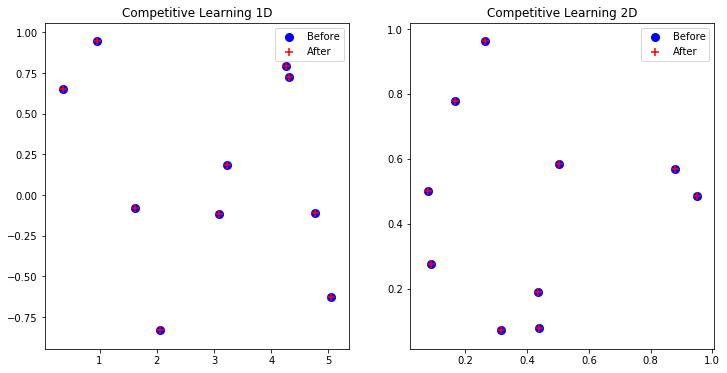

In [23]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(mu_before,np.sin(2*mu_before), marker='o', s=64, c='b', label="Before")
ax1.scatter(mu_after,np.sin(2*mu_after), marker='+', s=64, c='r', label="After")
ax1.set_title('Competitive Learning 1D')
ax1.legend()


ax2.scatter(mu_before_2D[0,:],mu_before_2D[1,:], marker='o', s=64, c='b', label="Before")
ax2.scatter(mu_after_2D[0,:],mu_after_2D[1,:], marker='+', s=64, c='r', label="After")
ax2.set_title('Competitive Learning 2D')
ax2.legend()

plt.show()